In [61]:
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import os
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

In [63]:
class SphereDataset(Dataset):
    def __init__(self, csv_path, images_dir, transform=None):
        self.data: pd.DataFrame = pd.read_csv(csv_path)
        self.images_dir = images_dir
        self.transform = transform
        self.inputs = None
        self.images = None
        self.prepare_data()

    def prepare_data(self):
        inputs = []
        images = []
        for idx in range(len(self.data)):
            row = self.data.iloc[idx]

            model_translation = np.array(eval(row['model_translation']), dtype=np.float32) / 20.0
            material_diffuse = np.array(eval(row['material_diffuse']), dtype=np.float32)
            material_shininess = float(row['material_shininess']) / 20.0
            light_position = np.array(eval(row['light_position']), dtype=np.float32) / 20.0

            input_vec = np.concatenate([model_translation, material_diffuse, [material_shininess], light_position])
            inputs.append(input_vec)

            img_path = os.path.join(self.images_dir, f"image_{int(row['frame']):04}.png")
            image = Image.open(img_path).convert("RGB").resize((128, 128))

            if self.transform:
                image = self.transform(image)

            images.append(image)

        self.inputs = torch.tensor(np.array(inputs), dtype=torch.float32)
        self.images = torch.stack(images)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.inputs[idx], self.images[idx]

In [64]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

dataset = SphereDataset("src/data.csv", "output", transform=transform)

In [65]:
dataset[0]

(tensor([-0.2500,  0.3000, -0.3500,  0.7098,  0.5725,  0.7765,  0.5000,  0.5500,
         -1.0000,  0.0500]),
 tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1

## GAN

In [106]:
class Generator(nn.Module):
    def __init__(self, input_dim=10, feature_map=64, img_size=128):
        super().__init__()
        self.img_size = img_size
        self.fc = nn.Sequential(
            nn.Linear(input_dim, feature_map * 8 * 8 * 8),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(feature_map * 8, feature_map * 4, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(feature_map * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map * 4, feature_map * 2, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(feature_map * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map * 2, feature_map, 4, 2, 1),      # 64x64
            nn.BatchNorm2d(feature_map),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map, 3, 4, 2, 1),                    # 128x128
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)  # [B, feat*8*8*8]
        x = x.view(-1, 512, 8, 8)
        return self.deconv(x)

In [107]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1),  # 64x64
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## Trening

In [181]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [182]:
loader = DataLoader(dataset, batch_size=16, shuffle=True)

criterion = nn.BCELoss()
mse_loss = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=[0.5, 0.999])
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005, betas=[0.5, 0.999])

In [183]:
from tqdm import tqdm

EPOCHS = 30
lambda_mse = 100

for epoch in range(EPOCHS):
    g_total_loss, d_total_loss = 0.0, 0.0

    for inputs, real_imgs in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        inputs = inputs.to(device)
        real_imgs = real_imgs.to(device)

        valid = torch.ones(inputs.size(0), 1).to(device) * 0.9
        fake = torch.zeros(inputs.size(0), 1).to(device) + 0.1

        # === Discriminator ===
        optimizer_D.zero_grad()
        with torch.no_grad():
            gen_imgs = generator(inputs)

        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # === Generator ===
        optimizer_G.zero_grad()
        gen_imgs = generator(inputs)
        adv_loss = criterion(discriminator(gen_imgs), valid)
        rec_loss = mse_loss(gen_imgs, real_imgs)
        g_loss = adv_loss + lambda_mse * rec_loss
        g_loss.backward()
        optimizer_G.step()

        g_total_loss += g_loss.item()
        d_total_loss += d_loss.item()

    print(f"[{epoch}] G_loss: {g_total_loss:.4f} | D_loss: {d_total_loss:.4f}")

Epoch 1/30: 100%|██████████| 125/125 [00:22<00:00,  5.59it/s]


[0] G_loss: 3975.7745 | D_loss: 57.5271


Epoch 2/30: 100%|██████████| 125/125 [00:22<00:00,  5.62it/s]


[1] G_loss: 1686.9096 | D_loss: 58.4686


Epoch 3/30: 100%|██████████| 125/125 [00:21<00:00,  5.86it/s]


[2] G_loss: 347.8464 | D_loss: 52.3280


Epoch 4/30: 100%|██████████| 125/125 [00:22<00:00,  5.62it/s]


[3] G_loss: 343.6637 | D_loss: 55.5061


Epoch 5/30: 100%|██████████| 125/125 [00:22<00:00,  5.61it/s]


[4] G_loss: 320.5883 | D_loss: 55.9403


Epoch 6/30: 100%|██████████| 125/125 [00:21<00:00,  5.86it/s]


[5] G_loss: 333.2621 | D_loss: 54.6283


Epoch 7/30: 100%|██████████| 125/125 [00:22<00:00,  5.62it/s]


[6] G_loss: 360.7590 | D_loss: 51.3836


Epoch 8/30: 100%|██████████| 125/125 [00:22<00:00,  5.62it/s]


[7] G_loss: 347.0193 | D_loss: 51.3990


Epoch 9/30: 100%|██████████| 125/125 [00:21<00:00,  5.90it/s]


[8] G_loss: 348.4504 | D_loss: 48.3700


Epoch 10/30: 100%|██████████| 125/125 [00:22<00:00,  5.65it/s]


[9] G_loss: 348.9529 | D_loss: 47.3333


Epoch 11/30: 100%|██████████| 125/125 [00:22<00:00,  5.66it/s]


[10] G_loss: 381.1154 | D_loss: 47.3293


Epoch 12/30: 100%|██████████| 125/125 [00:21<00:00,  5.88it/s]


[11] G_loss: 352.3502 | D_loss: 47.2750


Epoch 13/30: 100%|██████████| 125/125 [00:22<00:00,  5.65it/s]


[12] G_loss: 342.2211 | D_loss: 47.7314


Epoch 14/30: 100%|██████████| 125/125 [00:22<00:00,  5.62it/s]


[13] G_loss: 355.7206 | D_loss: 48.8968


Epoch 15/30: 100%|██████████| 125/125 [00:21<00:00,  5.90it/s]


[14] G_loss: 338.5125 | D_loss: 48.0225


Epoch 16/30: 100%|██████████| 125/125 [00:22<00:00,  5.63it/s]


[15] G_loss: 347.2685 | D_loss: 48.7708


Epoch 17/30: 100%|██████████| 125/125 [00:22<00:00,  5.65it/s]


[16] G_loss: 362.3780 | D_loss: 54.1262


Epoch 18/30: 100%|██████████| 125/125 [00:21<00:00,  5.89it/s]


[17] G_loss: 346.5003 | D_loss: 53.1043


Epoch 19/30: 100%|██████████| 125/125 [00:22<00:00,  5.64it/s]


[18] G_loss: 347.9626 | D_loss: 52.1518


Epoch 20/30: 100%|██████████| 125/125 [00:22<00:00,  5.63it/s]


[19] G_loss: 343.3791 | D_loss: 51.6135


Epoch 21/30: 100%|██████████| 125/125 [00:21<00:00,  5.88it/s]


[20] G_loss: 332.8550 | D_loss: 53.4472


Epoch 22/30: 100%|██████████| 125/125 [00:22<00:00,  5.65it/s]


[21] G_loss: 333.7790 | D_loss: 53.1398


Epoch 23/30: 100%|██████████| 125/125 [00:22<00:00,  5.63it/s]


[22] G_loss: 344.8084 | D_loss: 50.6303


Epoch 24/30: 100%|██████████| 125/125 [00:21<00:00,  5.87it/s]


[23] G_loss: 330.3676 | D_loss: 54.9942


Epoch 25/30: 100%|██████████| 125/125 [00:22<00:00,  5.64it/s]


[24] G_loss: 330.2744 | D_loss: 53.4055


Epoch 26/30: 100%|██████████| 125/125 [00:22<00:00,  5.62it/s]


[25] G_loss: 337.6240 | D_loss: 52.5834


Epoch 27/30: 100%|██████████| 125/125 [00:21<00:00,  5.87it/s]


[26] G_loss: 332.6913 | D_loss: 55.2294


Epoch 28/30: 100%|██████████| 125/125 [00:22<00:00,  5.62it/s]


[27] G_loss: 341.1714 | D_loss: 55.0680


Epoch 29/30: 100%|██████████| 125/125 [00:22<00:00,  5.62it/s]


[28] G_loss: 340.5324 | D_loss: 51.0831


Epoch 30/30: 100%|██████████| 125/125 [00:21<00:00,  5.86it/s]

[29] G_loss: 329.8586 | D_loss: 54.8336


In [184]:
torch.save(generator.state_dict(), "generator1.pth")
torch.save(discriminator.state_dict(), "discriminator1.pth")

In [ ]:
# generator = Generator().to(device)
# discriminator = Discriminator().to(device)

# generator.load_state_dict(torch.load("generator.pth"))
# discriminator.load_state_dict(torch.load("discriminator.pth"))

In [185]:
def generate_random_input():
    model_translation = np.random.uniform(-20, 20, 3) / 20.0
    material_diffuse = np.random.uniform(0, 255, 3) / 255.0
    material_shininess = np.random.uniform(3, 20, 1) / 20.0
    light_position = np.random.uniform(-20, 20, 3) / 20.0
    input_vec = np.concatenate([model_translation, material_diffuse, material_shininess, light_position]).astype(np.float32)
    return torch.tensor(input_vec)


def denormalize(img: torch.Tensor):
    return (img + 1) / 2

tensor([-0.1500, -0.2000, -0.3000,  0.2000,  0.2941,  0.2196,  0.2500,  0.0000,
         0.8500, -0.1000])


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

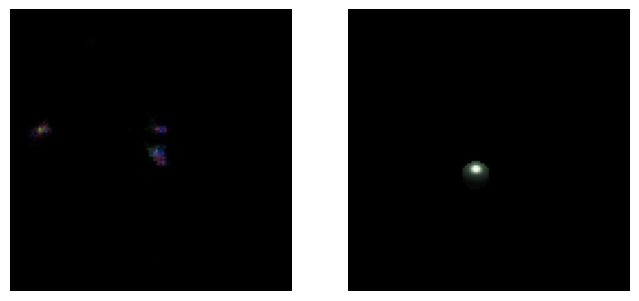

In [ ]:
input, img = dataset[90]
print(input)
fig, axes = plt.subplots(1, 2, figsize=(8, 16))

generated_img = generator(input.to(device).unsqueeze(0))
generated_img = denormalize(generated_img.squeeze(0))
img_np = generated_img.cpu().detach().numpy().transpose(1, 2, 0)
axes[0].imshow(img_np)
axes[0].axis('off')


axes[1].imshow(denormalize(img.cpu().detach().numpy().transpose(1, 2, 0)))
axes[1].axis('off')

tensor([-0.3468,  0.6428,  0.8490,  0.7769,  0.5823,  0.1120,  0.8950,  0.3572,
        -0.4826,  0.2236])


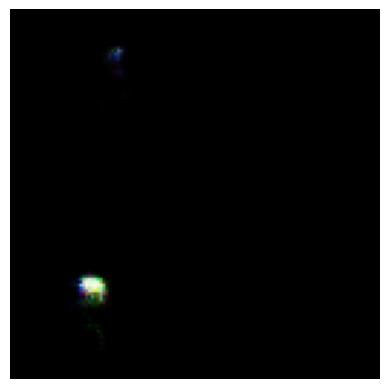

In [199]:
input_tensor = generate_random_input()
# input_tensor = torch.Tensor([-0.1, 0.3, -0.1, 0.7, 0.5, 0.7, 1.0, 0.2, -0.2, 0.1])
print(input_tensor)

with torch.no_grad():
    generated_img = generator(input_tensor.to(device).unsqueeze(0))
    generated_img = denormalize(generated_img.squeeze(0))

img_np = generated_img.cpu().detach().numpy().transpose(1, 2, 0)

plt.imshow(img_np)
plt.axis('off')
plt.show()